In [77]:
import os
import glob
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

import csv

In [ ]:

def read_patient_nii_mask(UID, seg_dir):
    nii_path = os.path.join(seg_dir, f"{UID}.nii")
    seg_mask = nib.load(nii_path).get_fdata()
    seg_mask = np.rot90(seg_mask, axes=(0, 1))
    seg_mask = seg_mask.transpose((2, 0, 1))
    seg_mask = np.flip(seg_mask, axis=0)
    seg_mask[seg_mask > 7] = 0
    return seg_mask

In [ ]:
DATA_DIR = "/Volumes/SSD970/"

TRAIN_SEG_DIR = os.path.join(DATA_DIR, "segmentations")

In [ ]:
patient_id = "1.2.826.0.1.3680043.1363"
masks = read_patient_nii_mask(patient_id, TRAIN_SEG_DIR)
masks.shape

In [ ]:
xray_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_xray.csv')).set_index('UID')
xray_df.head()

In [ ]:
xray_seg = masks.max(axis=2)
aspect = xray_df.loc[patient_id].iloc[0].aspect
print(aspect)
_, axs = plt.subplots(1, 2, figsize=(12, 12))
# axs.set_aspect(10)
axs[0].axis('off')
axs[0].imshow(xray_seg, cmap='bone')
axs[0].set_aspect(aspect)

xray_img = Image.open(os.path.join(DATA_DIR, 'xray_images', patient_id, 'sagittal.jpeg'))
axs[1].imshow(xray_img, cmap='bone')
plt.show()

In [ ]:
xray_seg.shape

In [78]:
header = [
    'UID', 'xmin','ymin','xmax','ymax','aspect'
]

f = open('segmentation_sagittal_bbox.csv','w',newline='')
writer = csv.writer(f)
writer.writerow(header)

32

134.0 123.73333333333336 362.0 550.4000000000001


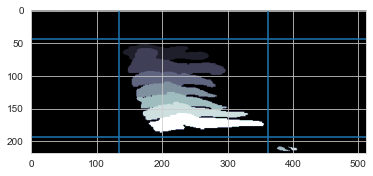

In [135]:
def find_segmentation_boundary(xray_seg, throw=100, tol=0.01):
    h, w = xray_seg.shape
    rows, columns = xray_seg.nonzero()
    rows.sort()
    columns.sort()

    ymin, ymax = rows[throw] , rows[-throw]
    xmin, xmax = columns[throw], columns[-throw]

    width_tol = (xmax - xmin) * tol
    height_tol = (ymax - ymin) * tol

    xmin -= width_tol
    xmax += width_tol
    ymin -= height_tol
    ymax += height_tol

    xmin = max(0, xmin)
    xmax = min(w, xmax)
    ymin = max(0, ymin)
    ymax = min(h, ymax)

    return xmin, ymin, xmax, ymax

UID = '1.2.826.0.1.3680043.28665'
masks = read_patient_nii_mask(UID, TRAIN_SEG_DIR)
xray_seg = masks.max(axis=2)
aspect = xray_df.loc[UID].iloc[0].aspect
xmin, ymin, xmax, ymax = find_segmentation_boundary(xray_seg, throw=200, tol=0.1)
print(xmin, ymin * aspect, xmax, ymax * aspect)
plt.imshow(xray_seg, cmap='bone')
# plt.axis('off')
plt.axvline(xmin)
# plt.axvline(330)
plt.axvline(xmax)
plt.axhline(ymin)
# plt.axhline(100)
plt.axhline(ymax)


In [79]:

nii_paths = glob.glob(os.path.join(DATA_DIR, 'segmentations') + '/*.nii')

for nii_path in tqdm(nii_paths):
    UID = nii_path.split("/")[-1].replace(".nii","")
    masks = read_patient_nii_mask(UID, TRAIN_SEG_DIR)
    xray_seg = masks.max(axis=2)
    aspect = xray_df.loc[UID].iloc[0].aspect
    xmin, ymin, xmax, ymax = find_segmentation_boundary(xray_seg, throw=100, tol=0.1)

    writer.writerow([
        UID, xmin, ymin * aspect, xmax, ymax * aspect, aspect
    ])

100%|██████████| 87/87 [01:35<00:00,  1.10s/it]


In [80]:
f.close()

,xmin,ymin,xmax,ymax,aspect
UID,,,,,
1.2.826.0.1.3680043.10633,128.3,167.978082,484.7,614.049315,1.753425
1.2.826.0.1.3680043.10921,196.8,70.400053,439.2,490.541546,1.882354
1.2.826.0.1.3680043.11827,66.5,69.764885,300.5,358.204580,1.954198
1.2.826.0.1.3680043.11988,75.0,124.000000,375.0,697.210000,3.436242
1.2.826.0.1.3680043.12281,46.8,127.733333,493.2,834.933333,2.666667


[134. 123. 362. 550.]


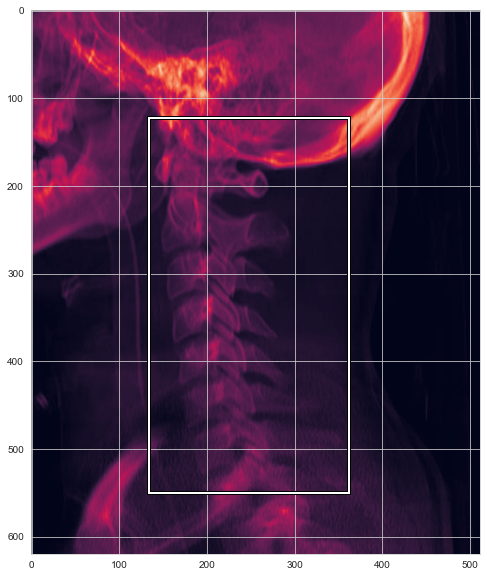

In [136]:
bbox_df = pd.read_csv('segmentation_sagittal_bbox.csv').set_index('UID')
# bbox_df["ymin"] = bbox_df["ymin"] * bbox_df["aspect"]
# bbox_df["ymax"] = bbox_df["ymax"] * bbox_df["aspect"]
bbox_df.head()
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
        plot_ax,
        bboxes,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
        image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    """

    :param image:
    :param bboxes: [[xmin, ymin, xmax, ymax]]
    :param draw_bboxes_fn:
    :param figsize:
    :return:
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

# UID = '1.2.826.0.1.3680043.23904'
bbox = bbox_df.loc[UID,['xmin','ymin','xmax','ymax']].values
print(bbox)
image = Image.open(os.path.join(DATA_DIR, 'xray_images',UID,'sagittal.jpeg'))
show_image(image, [bbox])